In [13]:
!pip install cma

In [14]:
import os
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cma
from scipy.stats import gaussian_kde

In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)

print(f"Using device: {DEVICE}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

Using device: cuda
Device name: Tesla T4


# Loading the Dataset

In [16]:
df = pd.read_csv("xy_data.csv")
obs_np = df[['x','y']].to_numpy(np.float32)
print(f"Loaded {len(obs_np)} points.")
print(df.describe())

Loaded 1500 points.
                 x            y
count  1500.000000  1500.000000
mean     83.713931    58.263519
std      13.697157     7.696524
min      59.657204    46.032295
25%      72.282910    51.124211
50%      84.710995    57.681288
75%      93.368257    66.138374
max     109.231520    69.685510


# Parametric Functions

In [17]:
def model_xy_torch(t, theta_deg, M, X):
    theta = torch.deg2rad(theta_deg)
    exp_term = torch.exp(M * torch.abs(t))
    sin03t = torch.sin(0.3 * t)

    x = t * torch.cos(theta) - exp_term * sin03t * torch.sin(theta) + X
    y = 42.0 + t * torch.sin(theta) + exp_term * sin03t * torch.cos(theta)

    return torch.stack([x, y], dim=1)

# Loss Function

In [18]:
def batched_l1(obs_xy, pred_xy, batch_obs=1500, batch_pred=2000):
    min_vals = []
    N_obs = obs_xy.shape[0]
    for i in range(0, N_obs, batch_obs):
        obs_batch = obs_xy[i:i+batch_obs]
        cur_min = None
        for j in range(0, pred_xy.shape[0], batch_pred):
            pred_batch = pred_xy[j:j+batch_pred]
            diff = torch.abs(obs_batch.unsqueeze(1) - pred_batch.unsqueeze(0))
            dman = diff.sum(dim=2)
            local_min, _ = torch.min(dman, dim=1)
            cur_min = local_min if cur_min is None else torch.minimum(cur_min, local_min)
        min_vals.append(cur_min)
    return torch.cat(min_vals, dim=0).mean()

def evaluate_loss(obs_xy_np, theta, M, X, t_samples, normalize=True, device=DEVICE):
    obs_xy = torch.tensor(obs_xy_np, device=device)
    if normalize:
        mu = obs_xy.mean(dim=0)
        sigma = obs_xy.std(dim=0)
        sigma = torch.clamp(sigma, min=1e-6)
        obs_xy = (obs_xy - mu) / sigma
    else:
        mu = torch.tensor([0.,0.], device=device)
        sigma = torch.tensor([1.,1.], device=device)

    t = torch.tensor(t_samples, device=device)

    # Explicitly cast to float32 to avoid dtype mismatch from CMA (usually float64)
    pred_xy = model_xy_torch(t, torch.tensor(theta, device=device, dtype=torch.float32),
                             torch.tensor(M, device=device, dtype=torch.float32),
                             torch.tensor(X, device=device, dtype=torch.float32))
    if normalize:
        pred_xy = (pred_xy - mu) / sigma

    mean_min = batched_l1(obs_xy, pred_xy)
    return mean_min.item()

# CMA-ES Optimizer

In [19]:
def cmaes_global_search(obs_xy_np, t_samples, x0, sigma0, max_iter):
    print(f"[CMA-ES] Running CMA-ES global search for {max_iter} iterations on 3 parameter dimensions.)")

    # Objective function for CMA-ES
    def objective_function(params):
        theta, M, X = params[0], params[1], params[2]
        return evaluate_loss(obs_xy_np, theta, M, X, t_samples, normalize=USE_NORMALIZE)

    # Ensure the parameters bound
    bounds = [THETA_BOUNDS, M_BOUNDS, X_BOUNDS]
    lower_bounds = [b[0] for b in bounds]
    upper_bounds = [b[1] for b in bounds]

    # Run CMA-ES
    es = cma.CMAEvolutionStrategy(
        x0=x0,
        sigma0=np.mean(sigma0), # Initial step size
        inopts={
            'bounds': [lower_bounds, upper_bounds],
            'CMA_diagonal': 0, # Full Covariance matrix
            'maxiter': max_iter
        }
    )

    # Optimize
    es.optimize(objective_function)

    best_pos = es.result.xbest
    best_cost = es.result.fbest

    print(f"CMA-ES Optimizer Minimum L1 loss={best_cost:.6f}")
    print(f"CMA-ES Best Calculated Parameters: θ={best_pos[0]:.6f}, M={best_pos[1]:.6f}, X={best_pos[2]:.6f}")

    return best_pos # Returns [theta, M, X] as numpy array (usually float64)

# L-BFGS Optimizer

In [20]:
def lbfgs_refine(obs_xy_np, init_params, t_samples, steps=200, lr=0.5):
    print("LBFGS refinement starting")
    obs_xy = torch.tensor(obs_xy_np, device=DEVICE)
    if USE_NORMALIZE:
        mu = obs_xy.mean(dim=0)
        sigma = obs_xy.std(dim=0)
        sigma = torch.clamp(sigma, min=1e-6)
    else:
        mu = torch.tensor([0.,0.], device=DEVICE)
        sigma = torch.tensor([1.,1.], device=DEVICE)

    t = torch.tensor(t_samples, device=DEVICE)

    # Ensure init_params is a float array before creating tensors
    init_params = np.asarray(init_params, dtype=np.float32)

    # Base params
    theta = torch.tensor([init_params[0]], device=DEVICE, requires_grad=True)
    M = torch.tensor([init_params[1]], device=DEVICE, requires_grad=True)
    X = torch.tensor([init_params[2]], device=DEVICE, requires_grad=True)

    params_to_optimize = [theta, M, X]

    optimizer = torch.optim.LBFGS(params_to_optimize, lr=lr, max_iter=steps, line_search_fn='strong_wolfe')

    def closure():
        optimizer.zero_grad()
        pred = model_xy_torch(t, theta, M, X)

        obs_n = (obs_xy - mu) / sigma
        pred_n = (pred - mu) / sigma

        loss = batched_l1(obs_n, pred_n)
        loss.backward()
        return loss

    optimizer.step(closure)

    # Clamp all parameters
    with torch.no_grad():
        theta.clamp_(*THETA_BOUNDS)
        M.clamp_(*M_BOUNDS)
        X.clamp_(*X_BOUNDS)

    final_loss = evaluate_loss(obs_xy_np, theta.item(), M.item(), X.item(), t_samples)

    print(f"LBFGS Optimization Done. Final L1 Loss={final_loss:.6f}")
    return (float(theta.item()), float(M.item()), float(X.item()), final_loss)

# Model Configuration

In [21]:
# Model Parameter Bounds
THETA_BOUNDS = (0.0, 50.0)
M_BOUNDS = (-0.05, 0.05)
X_BOUNDS = (0.0, 100.0)
T_MIN = 6.0
T_MAX = 60.0

# Optimization Config
USE_NORMALIZE = True
FINE_T = 8000 #
COARSE_T = 500 # Samples for CMA-ES global search
t_coarse = np.linspace(T_MIN, T_MAX, COARSE_T, dtype=np.float32)
t_fine = np.linspace(T_MIN, T_MAX, FINE_T, dtype=np.float32)

# CMA-ES Settings
CMAES_ITER = 50
CMAES_X0 = [25.0, 0.0, 50.0] # Initial guess of Mean Vector
CMAES_SIGMA0 = [5.0, 0.01, 10.0] # Initial guess of Step Size

# L-BFGS Settings
BFGS_ITER = 200

In [22]:
# --- CMA-ES + LBFGS Optimization Timing ---

# Overall timer
overall_start_time = time.time()

# CMA-ES Global Search
cmaes_start_time = time.time()
best_cmaes = cmaes_global_search(
    obs_np, t_coarse,
    x0=CMAES_X0,
    sigma0=CMAES_SIGMA0,
    max_iter=CMAES_ITER
)
cmaes_end_time = time.time()
cmaes_time = cmaes_end_time - cmaes_start_time
print(f"CMA-ES Global Search Time: {cmaes_time:.2f} seconds")

# LBFGS Refinement
lbfgs_start_time = time.time()
Theta_best, M_best, X_best, Final_loss = lbfgs_refine(
    np.array(obs_np),
    best_cmaes,
    t_fine,
    steps=BFGS_ITER
)
lbfgs_end_time = time.time()
lbfgs_time = lbfgs_end_time - lbfgs_start_time
print(f"LBFGS Refinement Time: {lbfgs_time:.2f} seconds")

# --- Final Summary ---
overall_end_time = time.time()
overall_time = overall_end_time - overall_start_time

print("\n=== FINAL RESULTS of CMA-ES + LBFGS Optimization ===")
print(f"Total Optimization Time: {overall_time:.2f} seconds")
print(f"  CMA-ES Time: {cmaes_time:.2f} seconds")
print(f"  LBFGS Time: {lbfgs_time:.2f} seconds")
print(f"Theta = {Theta_best:.6f}, M = {M_best:.6f}, X = {X_best:.6f}, Minimum Loss = {Final_loss:.6f}")

[CMA-ES] Running CMA-ES global search for 50 iterations on 3 parameter dimensions.)
(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=843596, Mon Nov 10 16:07:09 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 1.776535063982010e-01 1.0e+00 6.53e+00  3e-02  7e+00 0:00.0
    2     14 2.055265456438065e-01 1.2e+00 5.65e+00  3e-02  6e+00 0:00.0
    3     21 4.470935091376305e-02 1.3e+00 4.71e+00  2e-02  4e+00 0:00.0


/usr/local/lib/python3.12/dist-packages/cma/evolution_strategy.py:1312: UserWarning: Sampling standard deviation i=1 (and  others) at iteration 0 multiplied by 0.00666211414705011 to stds[1]=0.03333333333333333
  warnings.warn("Sampling standard deviation i={0}{4} at iteration {1}"


   50    350 3.820283105596900e-03 2.9e+00 1.74e-02  7e-06  1e-03 0:00.4
CMA-ES Optimizer Minimum L1 loss=0.003820
CMA-ES Best Calculated Parameters: θ=30.000043, M=0.029999, X=55.001177
CMA-ES Global Search Time: 0.43 seconds
LBFGS refinement starting
LBFGS Optimization Done. Final L1 Loss=0.000251
LBFGS Refinement Time: 0.13 seconds

=== FINAL RESULTS of CMA-ES + LBFGS Optimization ===
Total Optimization Time: 0.57 seconds
  CMA-ES Time: 0.43 seconds
  LBFGS Time: 0.13 seconds
Theta = 30.000044, M = 0.030000, X = 55.001179, Minimum Loss = 0.000251


# Plotting the Predicted Curve

Saved final_fit_cmaes_lbfgs_base_model.png


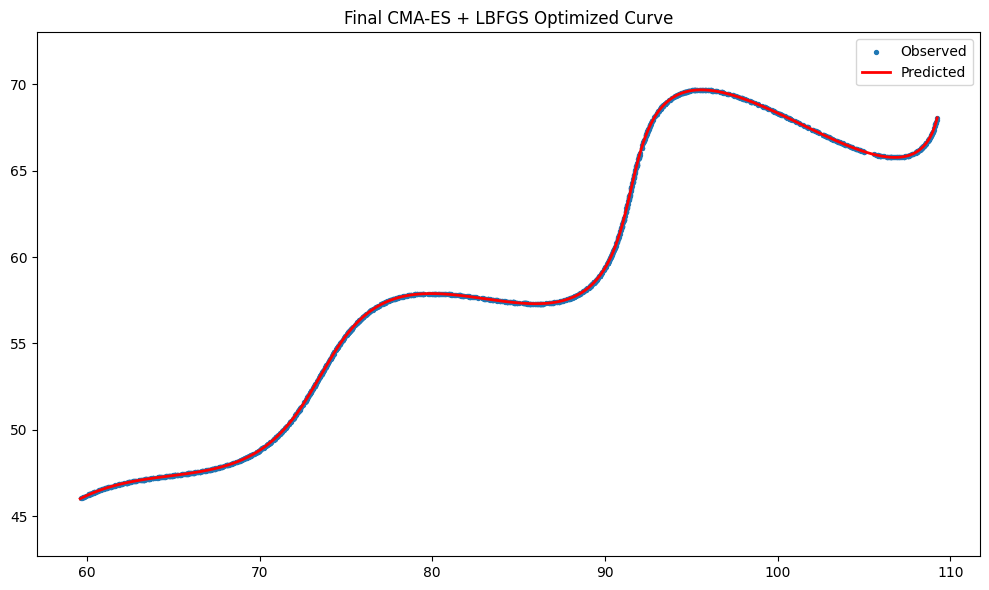

In [23]:
t_dense = np.linspace(T_MIN, T_MAX, 10000, dtype=np.float32)
t_t = torch.tensor(t_dense, device=DEVICE)

# Call Functions with FinalParameters
pred_xy = model_xy_torch(t_t,
                            torch.tensor(Theta_best, device=DEVICE),
                            torch.tensor(M_best, device=DEVICE),
                            torch.tensor(X_best, device=DEVICE)).cpu().numpy()

plt.figure(figsize=(10,6))
plt.scatter(obs_np[:,0], obs_np[:,1], s=8, c='tab:blue', label='Observed')
plt.plot(pred_xy[:,0], pred_xy[:,1], 'r', lw=2, label='Predicted')
plt.legend(); plt.axis('equal')
plt.title("Final CMA-ES + LBFGS Optimized Curve")
plt.tight_layout()
plt.savefig("final_fit_cmaes_lbfgs_base_model.png", dpi=200)
print("Saved final_fit_cmaes_lbfgs_base_model.png")

# Save summary
with open("Best_Parameters.txt","w") as f:
    f.write(f"Best θ={Theta_best:.8f}\nM={M_best:.12f}\nX={X_best:.8f}\nFinal Minimum Loss={Final_loss:.8f}\n")

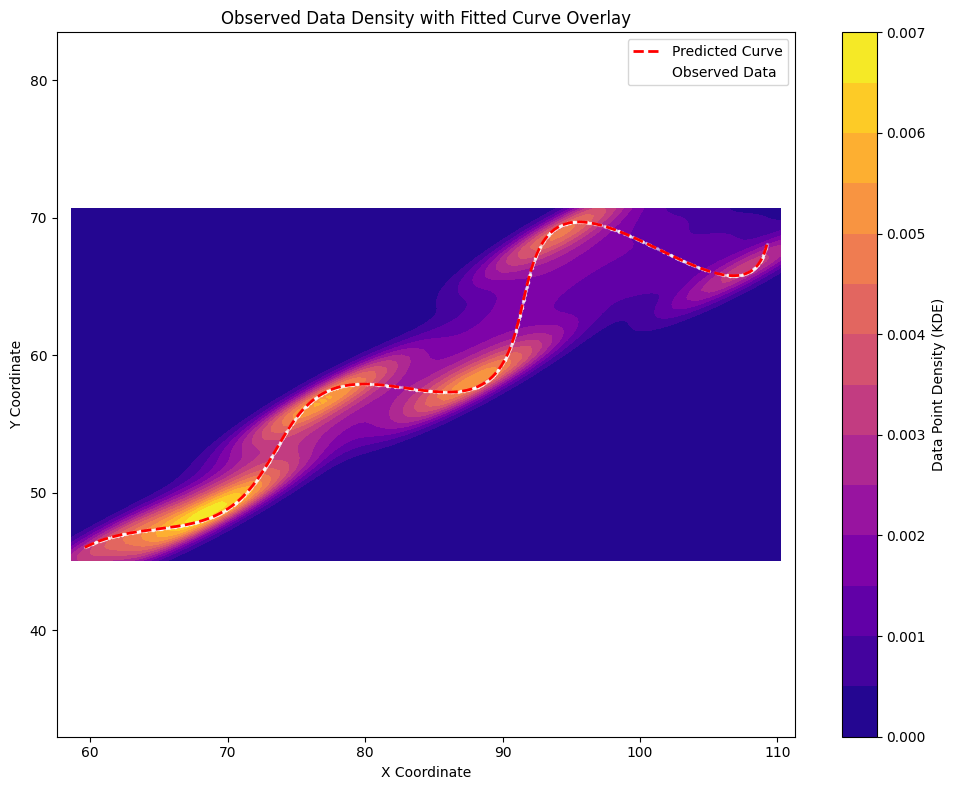

In [24]:
x_data = obs_np[:, 0]
y_data = obs_np[:, 1]

# Stack x and y data for the 2D KDE function
xy = np.vstack([x_data, y_data])
kde = gaussian_kde(xy)

xmin, xmax = x_data.min() - 1, x_data.max() + 1
ymin, ymax = y_data.min() - 1, y_data.max() + 1

# Create a 100x100 grid of points
X_grid, Y_grid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X_grid.ravel(), Y_grid.ravel()])

# Evaluate the KDE on the grid points
Z_kde = np.reshape(kde(positions).T, X_grid.shape)

# 3. Plotting the Density Contour
plt.figure(figsize=(10, 8))

# Plot the density contours (filled)
plt.contourf(X_grid, Y_grid, Z_kde, levels=15, cmap='plasma')
cbar = plt.colorbar()
cbar.set_label('Data Point Density (KDE)')

t_t = torch.tensor(t_dense, device=DEVICE)
pred_xy = model_xy_torch(t_t,
                            torch.tensor(Theta_best, device=DEVICE),
                            torch.tensor(M_best, device=DEVICE),
                            torch.tensor(X_best, device=DEVICE)).cpu().numpy()

plt.plot(pred_xy[:, 0], pred_xy[:, 1], 'r--', lw=2, label='Predicted Curve')
plt.scatter(x_data, y_data, s=2, c='white', alpha=0.3, label='Observed Data')
plt.legend()
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title("Observed Data Density with Fitted Curve Overlay")
plt.axis('equal') # Maintain aspect ratio
plt.tight_layout()
plt.savefig("density_contour_observed_data.png", dpi=200)
plt.show()